<a href="https://colab.research.google.com/github/L-kiad/DO/blob/main/email_classification_spam_or_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> IMPORTING LIBRARIES & DATASET </p>

In [2]:
!pip install optuna --q # For tuning hyperparameters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.4 MB/s eta 0:00:00


In [3]:
!pip install catboost lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.4 MB/s eta 0:00:00


In [4]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations
pd.set_option('display.max_columns', None) # code to display all columns

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# libraries for text processing and handling text data
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from collections import Counter

# all the required models
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# for model evaluation
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

# for hyperparameter tuning
import optuna

# to save the required files
import pickle

import warnings
warnings.filterwarnings('ignore') # To prevent kernel from showing any warning

In [5]:
# loading the dataset
df = pd.read_csv('/content/gdrive/MyDrive/mail_datasets/cleaned_data_body_label_nowords_nochars_nosent/cleaned_orgin_data.csv')
df.head()

,Body,Label,no_char,no_words,no_sent
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> INITIAL ANALYSIS </p>

In [6]:
# What is the data type of cols?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9108 entries, 0 to 9107
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Body      9104 non-null   object
 1   Label     9108 non-null   int64 
 2   no_char   9108 non-null   int64 
 3   no_words  9108 non-null   int64 
 4   no_sent   9108 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 355.9+ KB


In [7]:
# Are there any missing values?
df.isnull().sum()

Body        4
Label       0
no_char     0
no_words    0
no_sent     0
dtype: int64

In [8]:
# Are there any duplicate values?
df.duplicated().sum()

1045

<div style="color:white;
           display:fill;
           background-color:#562F5E;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Data contains 6046 rows and 3 columns <br>
           2. It has 1 string/object column, and one categorical column in int format <br>
           3. There's only 1 null value present <br>
           4. There are no duplicate values present within data <br>
    </div>

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> FEATURE ENGINEERING </p>

In [9]:
# dropping null values
df.dropna(inplace=True)

**For the purpose of data exploration, I am creating new features:**

* no_char: Number of characters in the email
* no_words: Number of words in the text email
* no_sent: Number of sentences in the text email

In [11]:
df.head()

,Body,Label,no_char,no_words,no_sent
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> EDA - I </p>

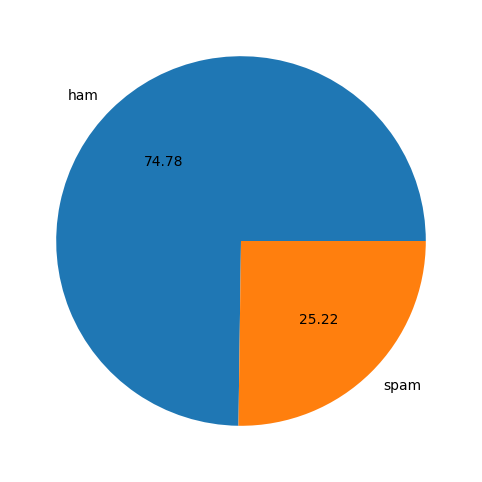

In [12]:
# Let's see the distribution of target variable
plt.figure(figsize=(12,6))
plt.pie(df['Label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

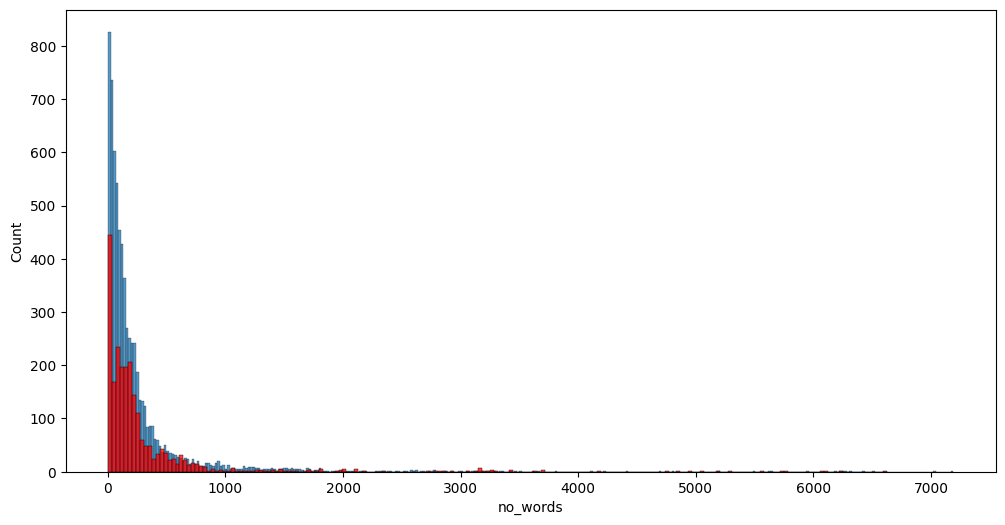

In [13]:
# Lets see the distribution of number of words in spam and ham emails
plt.figure(figsize=(12,6))
sns.histplot(df[df['Label'] == 0]['no_words'])
sns.histplot(df[df['Label'] == 1]['no_words'], color='red')
plt.show()

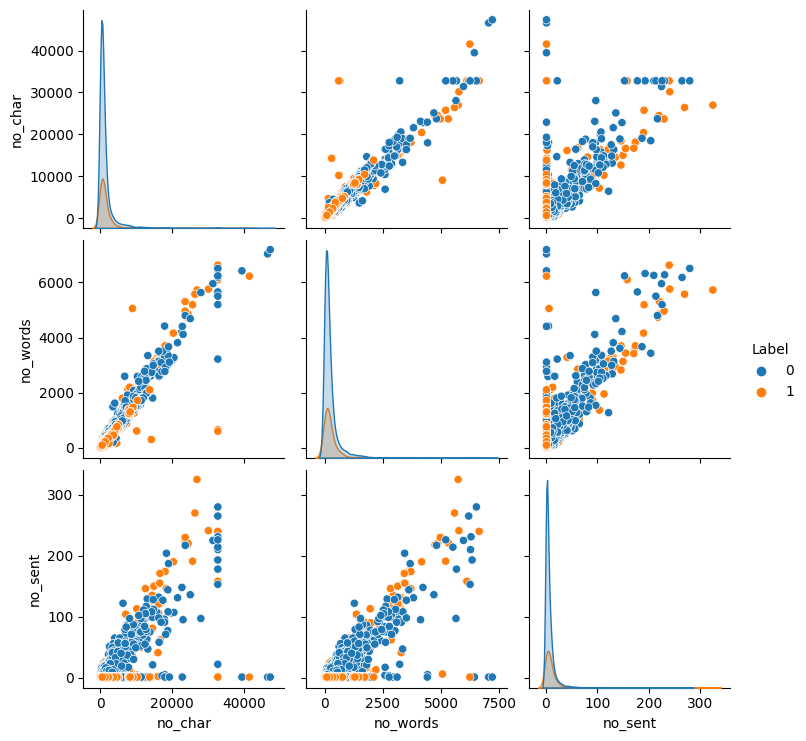

In [14]:
sns.pairplot(df, hue='Label')
plt.show()

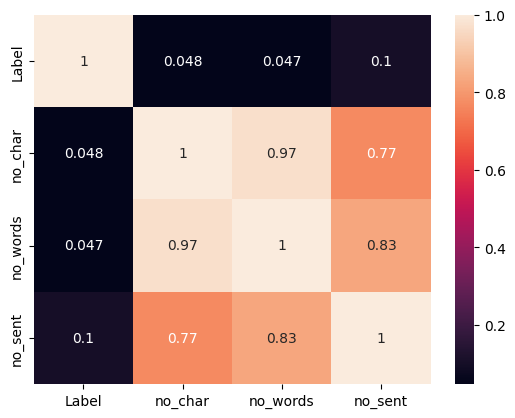

In [16]:
sns.heatmap(df.corr(), annot=True)
plt.show()

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> TEXT PREPROCESSING </p>

Chaque fois que nous avons des données textuelles, nous devons appliquer plusieurs étapes de prétraitement aux données pour transformer les mots en caractéristiques numériques qui fonctionnent avec les algorithmes d'apprentissage automatique. Les étapes de prétraitement pour un problème dépendent principalement du domaine et du problème lui-même, donc nous n'avons pas besoin d'appliquer toutes les étapes à chaque problème.

<b>Pour ce problème, j'ai créé une fonction qui effectue les étapes suivantes :</b>

*Minuscules du texte <br>
*Découpage en mots<br>
*Suppression des caractères spéciaux<br>
*Suppression des mots vides<br>
*Suppression de la ponctuation<br>
*Racinisation<br>

In [19]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
def text_preprocessing(text):
    # convert  text to lowecase
    text = text.lower()

    # creating list of words in email
    text = nltk.word_tokenize(text)

    # removing special charecters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # copying processed text to text and clearing y to store next steps output
    text = y[:]
    y.clear()

    # removing stopwords and punctuation marks
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    # stemming
    stemmer = SnowballStemmer('english')
    for i in text:
        y.append(stemmer.stem(i))

    return " ".join(y)

In [21]:
# applying function to text
df['clean_text'] = df['Body'].apply(text_preprocessing)

In [ ]:
df

,Body,Label,no_char,no_words,no_sent,clean_text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12,save 70 life insur spend life quot save ensur ...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5,1 fight risk cancer http slim guarante lose lb...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4,1 fight risk cancer http slim guarante lose lb...
3,##############################################...,1,2863,690,35,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4,thought might like 1 slim guarante lose lbs 30...
...,...,...,...,...,...,...
6041,empty,0,5,1,1,empti
6042,___ ___ ...,0,16999,3092,91,insignific matter heavili overemphasis hugh mt...
6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0,7299,1478,83,reader write extens search dumb messag revisit...
6044,empty,0,5,1,1,empti


# EXPLORATORY DATA ANALYSIS - II

Le nuage de mots est une technique de visualisation de données utilisée pour représenter des données textuelles où la taille de chaque mot indique sa fréquence ou son importance. Les points significatifs de données textuelles peuvent être mis en évidence à l'aide d'un nuage de mots.

In [22]:
# setting specs of word cloud image
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')

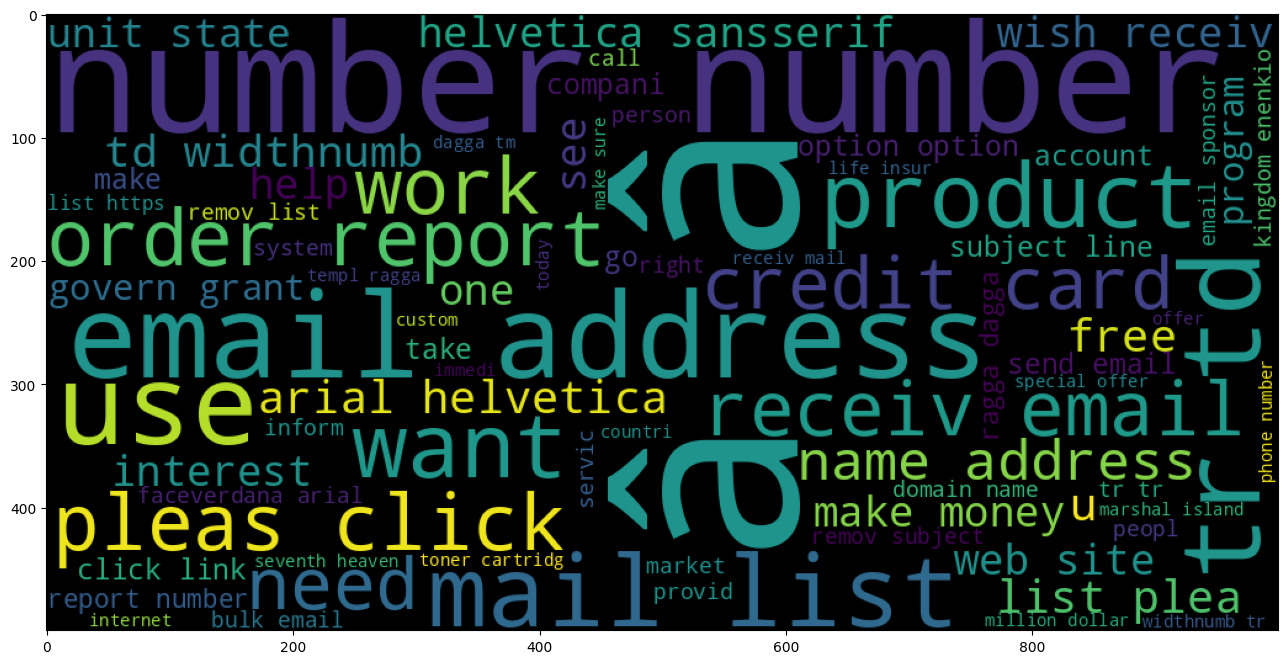

In [23]:
# creating word cloud of spam emails
spam_wc = wc.generate(df[df['Label'] == 1]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(spam_wc)

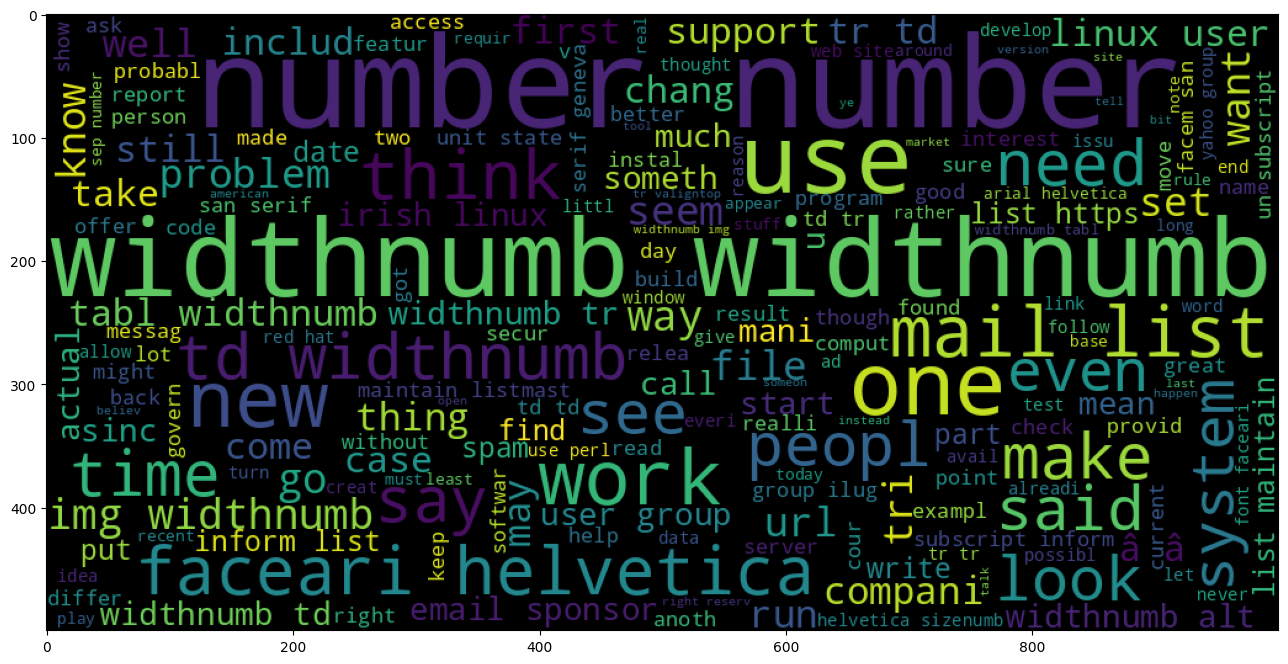

In [24]:
# creating word cloud of ham emails
ham_wc = wc.generate(df[df['Label'] == 0]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(ham_wc)

In [25]:
# creating list of all the words in processed spam emails
spam_corpus = []
for mail in df[df['Label'] == 1]['clean_text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

345839

In [26]:
# creating list of all the words in processed ham emails
ham_corpus = []
for mail in df[df['Label'] == 0]['clean_text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all ham mails
len(ham_corpus)

936955

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> TRAIN TEST SPLIT </p>

TF-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set).  

Tf-idf is one of the best metrics to determine how significant a term is to a text in a series or a corpus. tf-idf is a weighting system that assigns a weight to each word in a document based on its term frequency (tf) and the reciprocal document frequency (tf) (idf). The words with higher scores of weight are deemed to be more significant.

In [27]:
#Changing text data in to numbers.

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)

# Setting up features and target as x and y
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['Label'].values

In [28]:
# Splitting the testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

# <p style="background-color:#562F5E;font-family:verdana;color:white;font-size:100%;text-align:center;letter-spacing:0.5px;padding: 10px"> MODEL SELECTION </p>

In [29]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
bc = BaggingClassifier(n_estimators=50, random_state=0)
etc = ExtraTreesClassifier(n_estimators=50, random_state=0)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=0)
xgb = XGBClassifier(n_estimators=50,random_state=0)
sgd = SGDClassifier(random_state=0)
cat = CatBoostClassifier(verbose=0, random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [34]:
classifiers = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'SVC' : svc,
    'KNeighbors' : knc,
    'DecisionTree': dtc,
    'LogisticRegression': lrc,
    'RandomForest': rfc,
    'AdaBoost': abc,
    'BaggingClassifier': bc,
    'ExtraTreesClassifier': etc,
    'GradientBoosting': gbdt,
    'XGB': xgb,
    'SGD' : sgd,
    'Catboost' : cat,
    'LGBM' : lgbm
}

In [35]:
# creating a function to train list of algorithms and give accuracy , precision score
def train_classifier(classifiers,x_train,y_train,x_test,y_test):

    classifiers.fit(x_train,y_train)

    y_pred = classifiers.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

In [37]:
# storing accuracy and precision in list
accuracy_scores = []
precision_scores = []

# training all the models on training data
for name, classifier in classifiers.items():

    current_accuracy,current_precision = train_classifier(classifier, x_train,y_train,x_test,y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision,'\n')

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  GaussianNB
Accuracy -  0.9275123558484349
Precision -  0.8292682926829268 

For  MultinomialNB
Accuracy -  0.9406919275123559
Precision -  0.8990825688073395 

For  BernoulliNB
Accuracy -  0.9489291598023064
Precision -  0.9714285714285714 

For  SVC
Accuracy -  0.9632070291048874
Precision -  0.9026915113871635 

For  KNeighbors
Accuracy -  0.4623833058758924
Precision -  0.31387900355871884 

For  DecisionTree
Accuracy -  0.886326194398682
Precision -  0.7654584221748401 

For  LogisticRegression
Accuracy -  0.943437671609006
Precision -  0.8795698924731182 

For  RandomForest
Accuracy -  0.9648544755628775
Precision -  0.9083333333333333 

For  AdaBoost
Accuracy -  0.942339373970346
Precision -  0.8618556701030928 

For  BaggingClassifier
Accuracy -  0.9533223503569467
Precision -  0.8824742268041237 

For  ExtraTreesClassifier
Accuracy -  0.9654036243822076
Precision -  0.9119496855345912 

For  GradientBoosting
Accuracy -  0.9225700164744646
Precision -  0.8795180722891566 



Data Frame of accuracy and precision of models trained on all features

In [39]:
performance = pd.DataFrame({'Algorithm': classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance.sort_values('Accuracy', ascending=False)

,Algorithm,Accuracy,Precision
10,ExtraTreesClassifier,0.965404,0.911950
7,RandomForest,0.964854,0.908333
13,SGD,0.964854,0.904959
3,SVC,0.963207,0.902692
15,LGBM,0.962109,0.898969
14,Catboost,0.957166,0.900424
12,XGB,0.954970,0.894515
9,BaggingClassifier,0.953322,0.882474
2,BernoulliNB,0.948929,0.971429
6,LogisticRegression,0.943438,0.879570


In [41]:
performance.sort_values('Accuracy', ascending=False).head(5)

,Algorithm,Accuracy,Precision
10,ExtraTreesClassifier,0.965404,0.911950
7,RandomForest,0.964854,0.908333
13,SGD,0.964854,0.904959
3,SVC,0.963207,0.902692
15,LGBM,0.962109,0.898969


Accuracy :
L'accuracy est une mesure de la performance d'un modèle qui indique la proportion de prédictions correctes parmi toutes les prédictions effectuées. En d'autres termes, c'est le ratio des prédictions correctes (vrais positifs et vrais négatifs) sur l'ensemble des prédictions. L'accuracy est calculée comme suit :
<pre>
Accuracy = NPC/NPT
NPT: Nombre total de predictions
NPC: Nombre de predictions correctes
</pre>

L'accuracy est une métrique utile lorsque les classes sont équilibrées dans le jeu de données, c'est-à-dire lorsque le nombre d'exemples positifs et négatifs est à peu près le même. Cependant, l'accuracy peut être trompeuse si les classes sont déséquilibrées. Par exemple, si vous avez un jeu de données avec 95% de classe A et 5% de classe B, un modèle prédisant toujours la classe A obtiendrait une accuracy de 95%, mais il ne serait pas très utile en pratique.

Precision :
La précision est une métrique qui évalue la proportion de prédictions positives correctes parmi toutes les prédictions positives faites par le modèle. En d'autres termes, c'est le ratio des vrais positifs (prédictions positives correctes) sur l'ensemble des prédictions positives (vrais positifs + faux positifs). La précision est calculée comme suit :
<pre>
Precision =  VP / (VP + FP)
VP: Vrais Positifs
FP: Faux Positifs
</pre>

La précision est particulièrement importante lorsque les faux positifs sont coûteux ou indésirables. Par exemple, dans un système de détection de fraude, vous voudriez avoir une haute précision pour éviter de signaler des transactions légitimes comme frauduleuses.

Data Frame of accuracy and precision of models trained on max_features = 17000

In [43]:
performance_maxf17k = pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy_maxf17k':accuracy_scores,'Precision_maxf17k':precision_scores}).sort_values('Precision_maxf17k',ascending=False)
performance_maxf17k.sort_values('Accuracy_maxf17k', ascending=False).head(5)

,Algorithm,Accuracy_maxf17k,Precision_maxf17k
10,ExtraTreesClassifier,0.965404,0.911950
7,RandomForest,0.964854,0.908333
13,SGD,0.964854,0.904959
3,SVC,0.963207,0.902692
15,LGBM,0.962109,0.898969


We can clearly see algorithm trained on 17000 features giving us the best result

**Best Performing Models:**
* RandomForest
* SGD
* SVC
* LGBM

# HYPERPARAMETER TUNING

*Les paramètres qui définissent l'architecture du modèle sont appelés hyperparamètres, et ainsi ce processus de recherche de l'architecture de modèle idéale est appelé ajustement d'hyperparamètres.
*Les hyperparamètres ne sont pas des paramètres du modèle et ils ne peuvent pas être directement entraînés à partir des données. Les paramètres du modèle sont appris lors de l'entraînement lorsque nous optimisons une fonction de perte en utilisant quelque chose comme la descente de gradient.

*Les paramètres du modèle spécifient comment transformer les données d'entrée en la sortie souhaitée, les hyperparamètres définissent comment notre modèle est réellement structuré. Malheureusement, il n'y a pas de moyen de calculer "quelle direction devrais-je mettre à jour mon hyperparamètre pour réduire la perte ?" (c'est-à-dire les gradients) afin de trouver l'architecture de modèle optimale ; ainsi, nous avons généralement recours à l'expérimentation pour découvrir ce qui fonctionne le mieux.

**Ajustement des hyperparamètres avec Optuna :
Optuna est "une bibliothèque open-source d'optimisation d'hyperparamètres pour automatiser la recherche d'hyperparamètres optimaux". Les principales caractéristiques d'Optuna comprennent "la recherche automatisée d'hyperparamètres optimaux", "l'exploration efficace de grands espaces et l'élagage des essais peu prometteurs pour des résultats plus rapides" et "la parallélisation des recherches d'hyperparamètres sur plusieurs threads ou processus".

## Tunning Random Forest

In [44]:
def objective_rfc(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    rfc = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=0
    )

    return cross_val_score(rfc, x_train, y_train, n_jobs=-1, verbose=0, scoring='precision').mean()

In [45]:

study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective_rfc, n_trials=10)

best_params_rfc = study_rfc.best_trial.params

print('Best hyperparameters for RandomForest: {}'.format(best_params_rfc))

[I 2023-08-16 10:07:01,317] A new study created in memory with name: no-name-90d13c10-29e3-48c1-9b56-6511d371050c
[I 2023-08-16 10:07:14,418] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 0.38326295544673084, 'min_samples_leaf': 0.32894456819239126, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.
[I 2023-08-16 10:07:18,713] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 0.6655724723779268, 'min_samples_leaf': 0.4756966821704933, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.
[I 2023-08-16 10:07:24,120] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 0.6744716829250924, 'min_samples_leaf': 0.35429244601709653, 'max_features': 'auto'}. Best is trial 0 with value: 0.0.
[I 2023-08-16 10:07:36,247] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_

Best hyperparameters for RandomForest: {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 0.38326295544673084, 'min_samples_leaf': 0.32894456819239126, 'max_features': 'sqrt'}


In [46]:
# Créez un modèle RandomForest avec les meilleurs hyperparamètres trouvés
rfc = RandomForestClassifier(
    n_estimators=best_params_rfc['n_estimators'],
    max_depth=best_params_rfc['max_depth'],
    min_samples_split=best_params_rfc['min_samples_split'],
    min_samples_leaf=best_params_rfc['min_samples_leaf'],
    max_features=best_params_rfc['max_features'],
    random_state=0
)

# Entraînez le modèle avec les meilleurs hyperparamètres sur vos données d'entraînement
rfc.fit(x_train, y_train)

# Faites des prédictions sur les données de test et évaluez les performances
rfc_pred = rfc.predict(x_test)
print('Accuracy for RandomForest:', accuracy_score(y_test, rfc_pred))
print('Precision for RandomForest:', precision_score(y_test, rfc_pred))


Accuracy for RandomForest: 0.7495881383855024
Precision for RandomForest: 0.0


**Tuning BernoulliNB**

The first step is to define the objective function for Optuna to maximize or minimize. The objective function should take a “Trial” object as the input and return the score, a float value or a list of float values.

In [47]:
def objective_bnb(trial):
        alpha = trial.suggest_categorical('alpha', [0.7,0.8,0.9,1,1.1,1.2,1.3])
        binarize = trial.suggest_categorical('binarize', [0.0,0.1,0.2,0.3])

        bnb = BernoulliNB(
            alpha=alpha,
            binarize=binarize
        )
        return cross_val_score(bnb, x_train, y_train, n_jobs=-1, verbose=0, scoring='precision').mean()

The next step is to use the objective function to create a “Study” object and then optimize it.

In [48]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_bnb, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-16 10:13:11,159] A new study created in memory with name: no-name-e00c4ea6-8b5d-4be3-8c76-52ace7131fc3
[I 2023-08-16 10:13:25,377] Trial 0 finished with value: 0.9500320520962738 and parameters: {'alpha': 0.8, 'binarize': 0.1}. Best is trial 0 with value: 0.9500320520962738.
[I 2023-08-16 10:13:34,010] Trial 1 finished with value: 0.9628585398623282 and parameters: {'alpha': 1.3, 'binarize': 0.1}. Best is trial 1 with value: 0.9628585398623282.
[I 2023-08-16 10:13:43,462] Trial 2 finished with value: 0.9882352941176471 and parameters: {'alpha': 0.9, 'binarize': 0.3}. Best is trial 2 with value: 0.9882352941176471.
[I 2023-08-16 10:13:52,224] Trial 3 finished with value: 0.9628585398623282 and parameters: {'alpha': 1.3, 'binarize': 0.1}. Best is trial 2 with value: 0.9882352941176471.
[I 2023-08-16 10:14:00,733] Trial 4 finished with value: 0.9775933494760881 and parameters: {'alpha': 1.3, 'binarize': 0.0}. Best is trial 2 with value: 0.9882352941176471.
[I 2023-08-16 10:14:1

Accuracy: 0.9882352941176471
Best hyperparameters: {'alpha': 0.9, 'binarize': 0.3}


In [49]:
bnb = BernoulliNB(alpha=0.9, binarize=0.3)
bnb.fit(x_train,y_train)

bnb_pred = bnb.predict(x_test)
print('Accuracy:',accuracy_score(y_test,bnb_pred))
print('Precision:',precision_score(y_test,bnb_pred))

Accuracy: 0.7913234486545854
Precision: 0.9634146341463414


Nous avons réussi à augmenter la précision mais l'exactitude a diminué. J'ai beaucoup expérimenté et j'ai constaté qu'un des scores diminue si j'essaie d'augmenter les autres. Donc, je ne vais pas régler ce modèle car il me donne de meilleurs résultats de cette manière.

**Tuning SGDClassifier:**

In [50]:
def objective_sgd(trial):
        loss = trial.suggest_categorical('loss', ['hinge','log_loss','log','modified_huber','squared_hinge','perceptron'])
        penalty = trial.suggest_categorical('penalty', ['l2','l1','elasticnet'])
        l1_ratio = trial.suggest_categorical('l1_ratio', [0.2,0.5,0.8])
        max_iter = trial.suggest_categorical('max_iter', [100,500,1000])


        sgd = SGDClassifier(
                            early_stopping=True,
                            random_state=0,
                            loss=loss,
                            penalty=penalty,
                            l1_ratio=l1_ratio,
                            max_iter=max_iter
        )
        return cross_val_score(sgd, x_train, y_train, n_jobs=-1, verbose=0, scoring='precision').mean()

In [51]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_sgd, n_trials=20)

trial_sgd = study.best_trial

print('Accuracy: {}'.format(trial_sgd.value))
print("Best hyperparameters: {}".format(trial_sgd.params))

[I 2023-08-16 10:15:29,878] A new study created in memory with name: no-name-ea6512e5-35c0-4ec9-88a9-347e620ae082
[I 2023-08-16 10:15:51,609] Trial 0 finished with value: 0.860351939299649 and parameters: {'loss': 'perceptron', 'penalty': 'elasticnet', 'l1_ratio': 0.8, 'max_iter': 1000}. Best is trial 0 with value: 0.860351939299649.
[I 2023-08-16 10:16:18,887] Trial 1 finished with value: 0.8967547709015052 and parameters: {'loss': 'modified_huber', 'penalty': 'l1', 'l1_ratio': 0.8, 'max_iter': 100}. Best is trial 1 with value: 0.8967547709015052.
[I 2023-08-16 10:16:44,876] Trial 2 finished with value: 0.8956484161293276 and parameters: {'loss': 'log', 'penalty': 'l1', 'l1_ratio': 0.2, 'max_iter': 500}. Best is trial 1 with value: 0.8967547709015052.
[I 2023-08-16 10:17:13,404] Trial 3 finished with value: 0.8967547709015052 and parameters: {'loss': 'modified_huber', 'penalty': 'l1', 'l1_ratio': 0.5, 'max_iter': 100}. Best is trial 1 with value: 0.8967547709015052.
[I 2023-08-16 10:1

Accuracy: 0.9648266265580606
Best hyperparameters: {'loss': 'perceptron', 'penalty': 'l2', 'l1_ratio': 0.5, 'max_iter': 1000}


In [52]:
sgd = SGDClassifier(loss='perceptron',penalty='l2',l1_ratio=0.5,max_iter=1000)
sgd.fit(x_train,y_train)

sgd_pred = sgd.predict(x_test)
print('Accuracy:',accuracy_score(y_test,sgd_pred))
print('Precision:',precision_score(y_test,sgd_pred))


Accuracy: 0.9665019220208677
Precision: 0.8895463510848126


Nous avons augmenté la précision et l'exactitude semble également bonne.

Je donne plus d'importance à la précision, car la précision signifie le nombre d'e-mails légitimes classés comme spam, tandis que l'exactitude signifie le nombre d'e-mails correctement classés.

Je suis d'accord avec quelques e-mails indésirables qui ne sont pas classés comme spam, mais je ne veux pas qu'un seul e-mail légitime soit classé comme spam, car il pourrait être très important. C'est pourquoi je veux que la précision soit très élevée ainsi que l'exactitude.